In [1]:
import os 
import sys  # to interact with the python interpreter 
import requests # for http requests
import subprocess   # to spawn new processes, connect to their pipes, and obtain the return codes. Usefull for excuting shell commands from withing python
import shutil  # higher level interfacef for file operators. For copying and moving and deleting files and directories

# tracking events and erros in the application.
from logging import (
    getLogger, # creates or retrieves a logger object
    StreamHandler, 
    INFO
)

In [2]:
current_dir = os.getcwd()
current_dir

'/home/jhe378/works/mse803/_regression_gnn'

In [3]:
print(f"Python Version: {sys.version}")
print(f"Command-line arguments: {sys.argv}")

# sys.exit(0)

Python Version: 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
Command-line arguments: ['/home/jhe378/anaconda3/envs/py39/lib/python3.9/site-packages/ipykernel_launcher.py', '-f', '/home/jhe378/.local/share/jupyter/runtime/kernel-55478246-4e81-48a6-9c73-d61a4eedf64c.json']


In [4]:
# for running a shell command
result = subprocess.run(
    ['ls', '-l'], capture_output=True, text=True
)

print(f"Command output: \n{result.stdout})")
print(f"Return Code: {result.returncode}")

Command output: 
total 700
drwxr-xr-x 4 jhe378 domain users   4096 Nov 25 14:18 esol
-rw-r--r-- 1 jhe378 domain users  70492 Nov 25 15:25 model.pth
drwxr-xr-x 2 jhe378 domain users   4096 Nov 25 15:36 path_to_your_output_folder
-rw-r--r-- 1 jhe378 domain users 632906 Nov 25 15:48 sol_gnn.ipynb
)
Return Code: 0


In [5]:
import torch
import rdkit
from torch_geometric.datasets import MoleculeNet

from rdkit import Chem 
from rdkit.Chem.Draw import IPythonConsole

from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp 

from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

In [6]:
data = MoleculeNet(root=".", name="ESOL")

In [7]:
!ls

esol  model.pth  path_to_your_output_folder  sol_gnn.ipynb


In [8]:
data, len(data), type(data)

(ESOL(1128), 1128, torch_geometric.datasets.molecule_net.MoleculeNet)

In [9]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [10]:
# [num_nodes, num_node_features]
data[0].x  # Train 

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [11]:
# edges in sparse COO format
# [2, num_edges]

data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [12]:
data[0].y  # target # predictions based on the graph level

tensor([[-0.7700]])

In [13]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

In [14]:
data.y.shape

torch.Size([1128, 1])

In [15]:
type(data[0]), data[0]

(torch_geometric.data.data.Data,
 Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1]))

In [16]:
first_molecule = data[0]  # 假设data是一个列表，其中存储了多个molecule

# 显示节点特征
print("Node features shape:", first_molecule.x.shape)
print("Node features (first few nodes):", first_molecule.x[:5])  # 显示前五个节点的特征

# 显示边索引
print("Edge indices shape:", first_molecule.edge_index.shape)
print("Edge indices (sample):", first_molecule.edge_index[:, :5])  # 显示前五对边的索引

# 显示边属性
print("Edge attributes shape:", first_molecule.edge_attr.shape)
print("Edge attributes (sample):", first_molecule.edge_attr[:5])  # 显示前五条边的属性

Node features shape: torch.Size([32, 9])
Node features (first few nodes): tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1]])
Edge indices shape: torch.Size([2, 68])
Edge indices (sample): tensor([[0, 1, 1, 2, 2],
        [1, 0, 2, 1, 3]])
Edge attributes shape: torch.Size([68, 3])
Edge attributes (sample): tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])


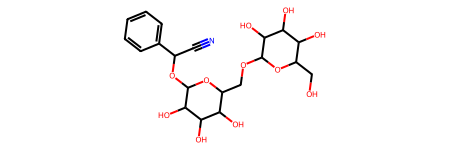

In [17]:
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

# GNN

In [18]:
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # init parent
        super(GCN, self).__init__()
        
        torch.manual_seed(42)
        
        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size) # size of input sample ---> size of embedding
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        
        # output layer 
        self.out = Linear(embedding_size * 2, 1) # we need just one ouput. Solvability of molecule in water
    
    def forward(self, x, edge_index, batch_index):
        # first conv
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        
        # next layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        
        hidden = F.tanh(self.conv2(hidden, edge_index))
        hidden = F.tanh(self.conv3(hidden, edge_index))
        
        # global pooling
        hidden = torch.cat(
            [
                gmp(hidden, batch_index),
                gap(hidden, batch_index)
            ], dim=1
        )
        
        out = self.out(hidden)
        return out, hidden

model = GCN()
print(model)

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


In [19]:
for p in model.parameters():
    print(p)
    print(p.numel())  # num of elements (numel) to get the total number of elements in the tensor
    break

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
64


In [20]:
sum(p.numel() for p in model.parameters())

13249

In [21]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device=device)
# wrap data in the data_loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 256
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

cuda


In [22]:
def train(data):
    for batch in loader:
        batch.to(device)
        optimizer.zero_grad()
        pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        
        optimizer.step()
    return loss, embedding

print("Starting....")

losses = []

for epoch in range(10000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss {loss}")
        

Starting....
Epoch 0 | Train Loss 11.597518920898438
Epoch 100 | Train Loss 1.6253312826156616
Epoch 200 | Train Loss 1.1865953207015991
Epoch 300 | Train Loss 1.3201546669006348
Epoch 400 | Train Loss 0.9732353687286377
Epoch 500 | Train Loss 0.6971800923347473
Epoch 600 | Train Loss 0.900115430355072
Epoch 700 | Train Loss 0.6901218891143799
Epoch 800 | Train Loss 0.44193094968795776
Epoch 900 | Train Loss 0.4598953425884247
Epoch 1000 | Train Loss 0.5387198328971863
Epoch 1100 | Train Loss 0.3968910574913025
Epoch 1200 | Train Loss 0.40458497405052185
Epoch 1300 | Train Loss 0.44392916560173035
Epoch 1400 | Train Loss 0.4266485571861267
Epoch 1500 | Train Loss 0.34678158164024353
Epoch 1600 | Train Loss 0.3523240089416504
Epoch 1700 | Train Loss 0.4004317820072174
Epoch 1800 | Train Loss 0.2343820035457611
Epoch 1900 | Train Loss 0.2967797517776489
Epoch 2000 | Train Loss 0.17035751044750214
Epoch 2100 | Train Loss 0.3230592906475067
Epoch 2200 | Train Loss 0.23026573657989502
Epoch

In [23]:
torch.save(model, 'model.pth')

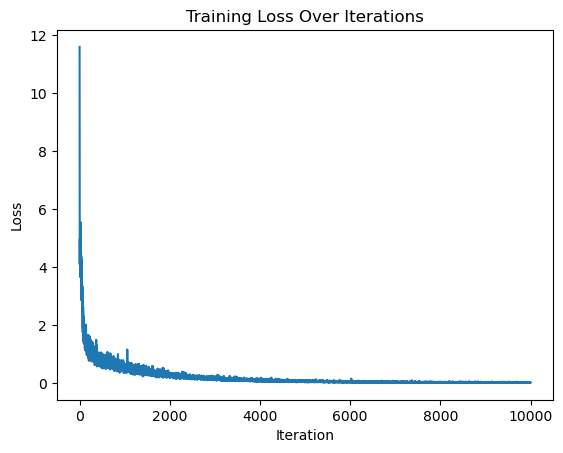

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i, _ in enumerate(losses_float)] 
sns.lineplot(x=loss_indices, y=losses_float)

# Display the plot
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Over Iterations")
plt.show()


In [25]:
import pandas as pd 

test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-1.850,-2.088322
1,-3.230,-2.969597
2,-2.050,-2.118404
3,-4.800,-5.742495
4,-3.224,-3.318637
...,...,...
221,-3.770,-4.671744
222,-1.380,-1.118619
223,-2.540,-2.479108
224,-3.091,-5.252886


MSE: 0.9140


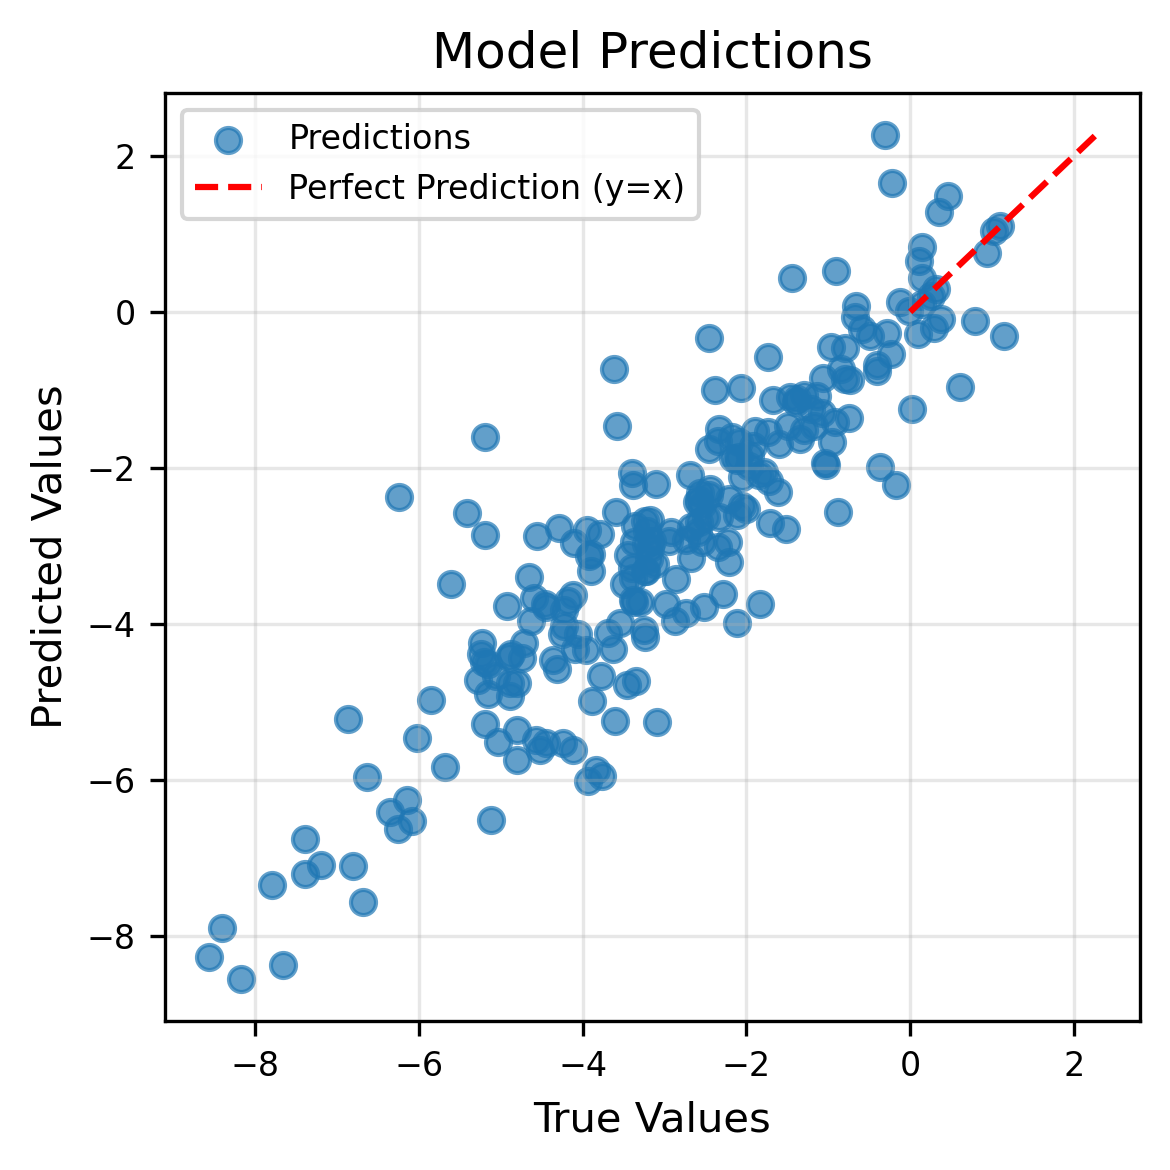

Scatter plot saved in path_to_your_output_folder


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import os

# 假设df已经准备好，并包含y_real和y_pred
mse = mean_squared_error(df['y_real'], df['y_pred'])
print(f"MSE: {mse:.4f}")

# 设置输出文件夹路径
output_folder_2d = "path_to_your_output_folder"  # 请替换为您的输出文件夹路径
if not os.path.exists(output_folder_2d):
    os.makedirs(output_folder_2d)

# 散点图绘制
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(df["y_real"], df["y_pred"], alpha=0.7, label="Predictions")
plt.plot(
    [0, max(df["y_real"].max(), df["y_pred"].max())],
    [0, max(df["y_real"].max(), df["y_pred"].max())],
    color="red", linestyle="--", label="Perfect Prediction (y=x)"
)
plt.title("Model Predictions", fontsize=12)  # 标题可以根据需要修改
plt.xlabel("True Values", fontsize=10)
plt.ylabel("Predicted Values", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_folder_2d, "model_predictions_scatter_plot.png"), dpi=300)
plt.show()

print(f"Scatter plot saved in {output_folder_2d}")

MSE: 0.9588


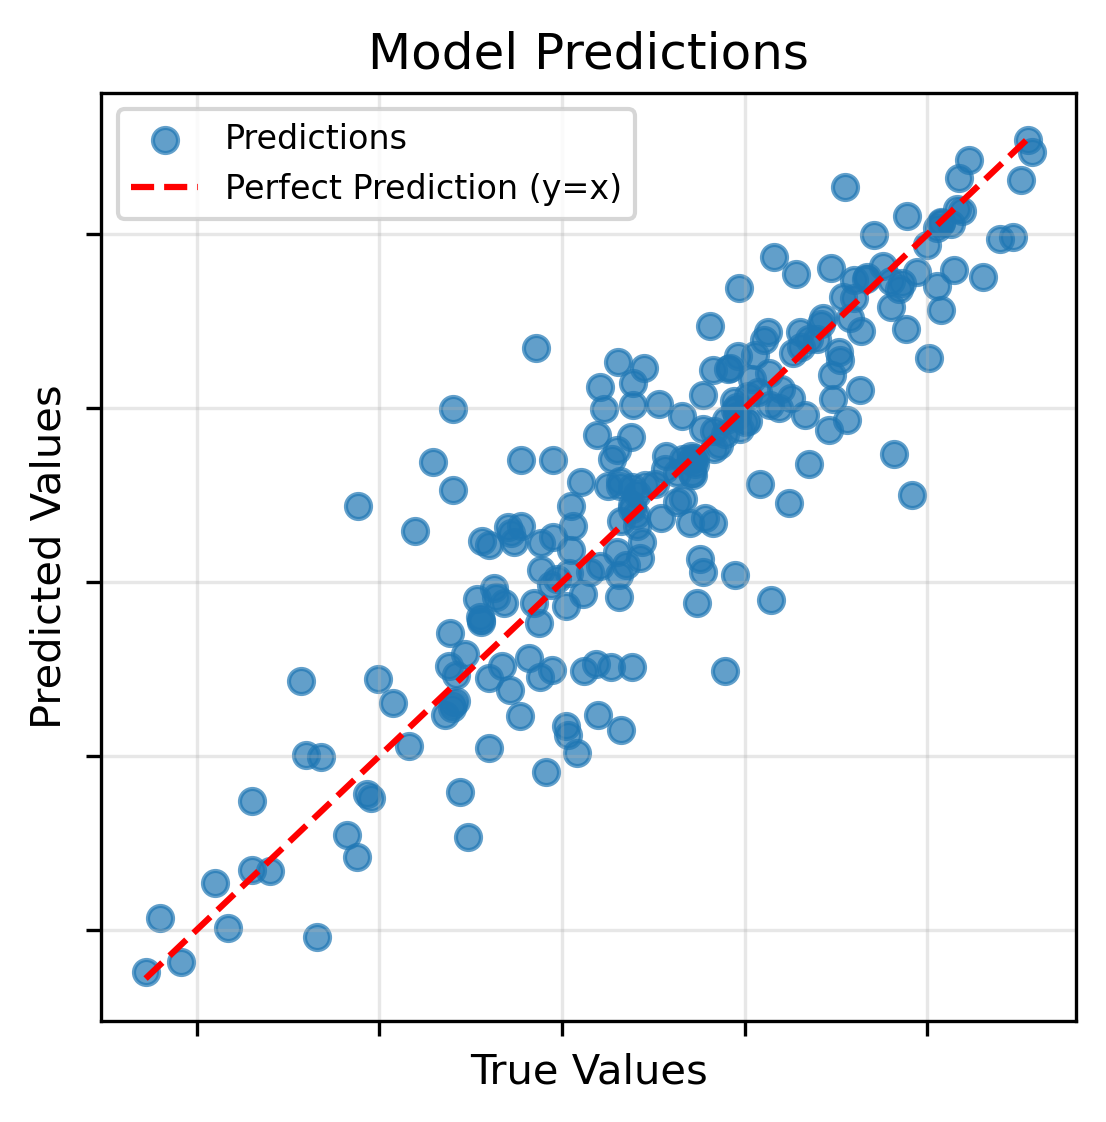

Scatter plot saved in path_to_your_output_folder


In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import os

# 假设df已经准备好，并包含y_real和y_pred
mse = mean_squared_error(df['y_real'], df['y_pred'])
print(f"MSE: {mse:.4f}")

# 设置输出文件夹路径
output_folder_2d = "path_to_your_output_folder"  # 请替换为您的输出文件夹路径
if not os.path.exists(output_folder_2d):
    os.makedirs(output_folder_2d)

# 计算对角线的坐标
min_val = min(df["y_real"].min(), df["y_pred"].min())
max_val = max(df["y_real"].max(), df["y_pred"].max())

# 散点图绘制
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(df["y_real"], df["y_pred"], alpha=0.7, label="Predictions")
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    'r--', label="Perfect Prediction (y=x)"
)
plt.title("Model Predictions", fontsize=12)  # 标题可以根据需要修改
plt.xlabel("True Values", fontsize=10)
plt.ylabel("Predicted Values", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_folder_2d, "model_predictions_scatter_plot.png"), dpi=300)
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)  # 不显示刻度值
plt.show()

print(f"Scatter plot saved in {output_folder_2d}")

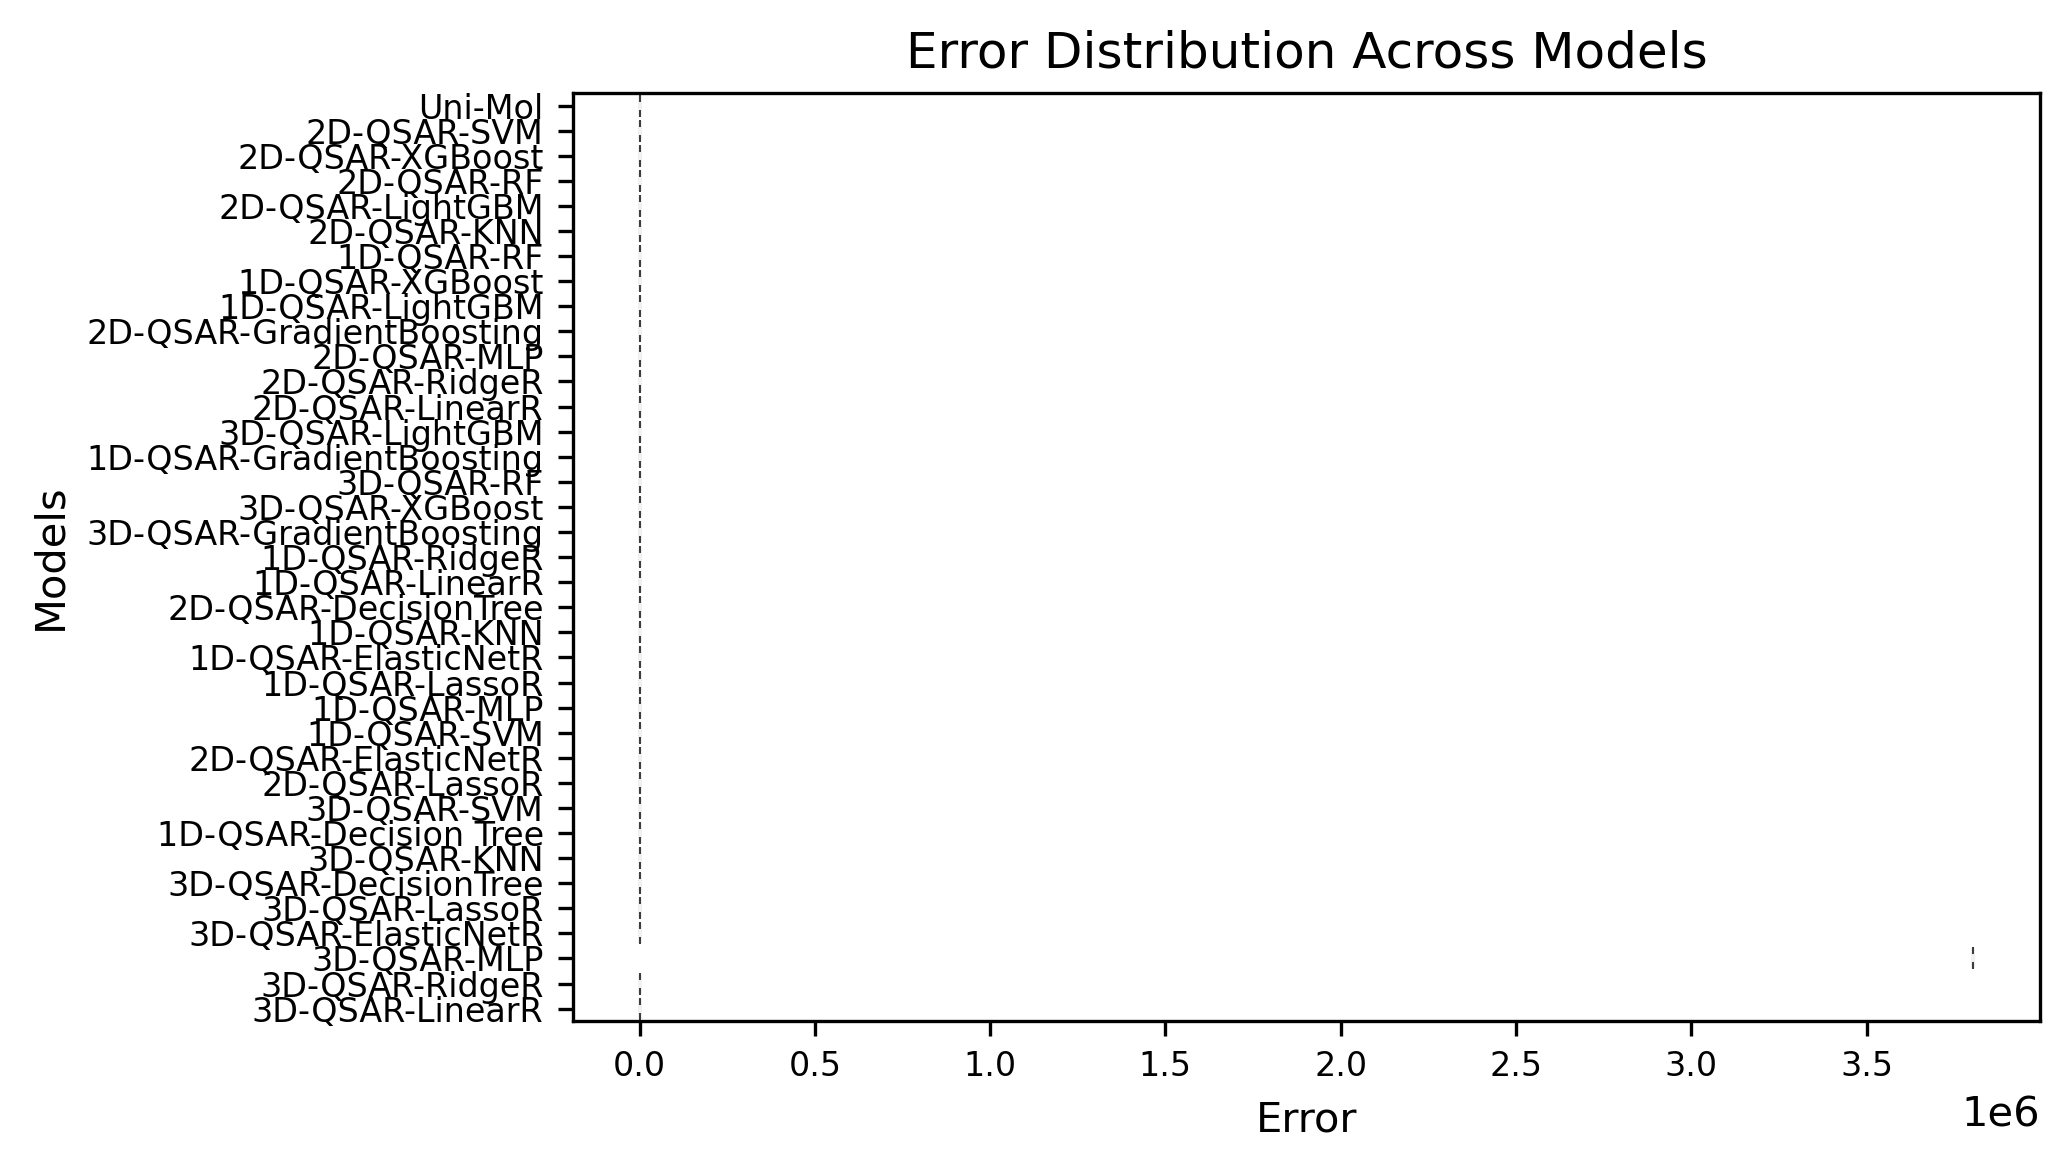

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Provided Data
data = {
    "Model": [
        "Uni-Mol", "2D-QSAR-SVM", "2D-QSAR-XGBoost", "2D-QSAR-RF", "2D-QSAR-LightGBM", 
        "2D-QSAR-KNN", "1D-QSAR-RF", "1D-QSAR-XGBoost", "1D-QSAR-LightGBM", 
        "2D-QSAR-GradientBoosting", "2D-QSAR-MLP", "2D-QSAR-RidgeR", "2D-QSAR-LinearR", 
        "3D-QSAR-LightGBM", "1D-QSAR-GradientBoosting", "3D-QSAR-RF", "3D-QSAR-XGBoost", 
        "3D-QSAR-GradientBoosting", "1D-QSAR-RidgeR", "1D-QSAR-LinearR", "2D-QSAR-DecisionTree", 
        "1D-QSAR-KNN", "1D-QSAR-ElasticNetR", "1D-QSAR-LassoR", "1D-QSAR-MLP", "1D-QSAR-SVM", 
        "2D-QSAR-ElasticNetR", "2D-QSAR-LassoR", "3D-QSAR-SVM", "1D-QSAR-Decision Tree", 
        "3D-QSAR-KNN", "3D-QSAR-DecisionTree", "3D-QSAR-LassoR", "3D-QSAR-ElasticNetR", 
        "3D-QSAR-MLP", "3D-QSAR-RidgeR", "3D-QSAR-LinearR"
    ],
    "Median Error": [
        0.419774, 0.455441, 0.459129, 0.47166, 0.479684, 0.480645, 0.605183, 0.605652, 0.642647, 
        0.669449, 0.693308, 0.715356, 0.715559, 0.730661, 0.760707, 0.783114, 0.810273, 0.866329, 
        0.885736, 0.885739, 0.889239, 0.911012, 0.926934, 0.928588, 0.938524, 0.939777, 1.010851, 
        1.010851, 1.042737, 1.057852, 1.194292, 1.598439, 805.758003, 2390.261763, 3482168556886455484416.0, 
        4392658479297741235159040.0, 34953863171341550859845632.0
    ],
    "Errors": [
        [2.522, 2.034, 2.124], [1.659, 1.802, 1.339], [1.524, 1.569, 0.739], [1.988, 2.382, 0.845], 
        [2.022, 2.592, 0.795], [1.51, 1.508, 0.975], [2.391, 2.477, 3.016], [2.51, 3.2, 2.426], 
        [2.347, 2.509, 2.554], [2.919, 2.653, 2.551], [1.12, 1.384, 1.224], [2.788, 2.147, 2.513], 
        [2.786, 2.143, 2.511], [3.854, 1.365, 1.63], [4.203, 4.083, 3.797], [3.555, 2.413, 2.851], 
        [3.826, 0.888, 1.363], [4.338, 2.899, 2.783], [4.533, 4.121, 4.016], [4.533, 4.121, 4.016], 
        [0.57, 0.18, 1.54], [2.524, 3.312, 4.324], [4.599, 4.317, 4.138], [4.597, 4.317, 4.133], 
        [4.539, 4.24, 4.049], [4.759, 4.453, 4.289], [4.57, 4.32, 4.09], [4.57, 4.32, 4.09], 
        [4.75, 4.5, 4.27], [2.524, 2.9, 2.355], [4.92, 4.12, 5.354], [3.03, 1.14, 1.659], 
        [4.569, 4.319, 4.089], [4.569, 4.319, 4.089], [3804401.305, 3804401.551, 3804401.44], 
        [4.324, 3.932, 3.681], [4.287, 3.435, 3.171]
    ]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Prepare data for violin plot
residuals_data = []
for index, row in df.iterrows():
    residuals = pd.DataFrame({
        "Model": row["Model"],
        "Error": row["Errors"]
    })
    residuals_data.append(residuals)

residuals_df = pd.concat(residuals_data, ignore_index=True)

# Sort models by median error
model_order = df.sort_values(by="Median Error")["Model"]

# Generate violin plot
plt.figure(figsize=(7, 4), dpi=300)
sns.violinplot(
    x="Error", y="Model", data=residuals_df, order=model_order,
    palette="muted", linewidth=0.5
)
plt.title("Error Distribution Across Models", fontsize=12)
plt.xlabel("Error", fontsize=10)
plt.ylabel("Models", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig("qasr_violin_plot.png")
plt.show()
